In [200]:
import sys  
sys.path.append("../..")
from bernSCM.run_bernSCM import *

from fair.SSPs import ssp245,ssp585
from fair import *

import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

%matplotlib inline

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'

### 1. Concentration based run
We first need to find emissions that ensure a constant atmospheric $CO_2$ concentration after the year of the pulse.

In [2]:
conc_in = return_empty_emissions(df_to_copy=False, start_year=1765, end_year=3100, timestep=1, scen_names=['yr_'+str(i) for i in range(1850,2006)], gases_in = ['methane'])

for label in ['yr_'+str(i) for i in range(1850,2016)]:
    t = int(label.split('yr_')[-1])

    conc_in.loc[:t,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year<=t]
    conc_in.loc[t:,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year==t]

test_gas = get_gas_parameter_defaults().reindex(conc_in.columns.levels[1],axis=1,level=1)

In [3]:
conc_out = run_FaIR(concentrations_in=conc_in,forcing_in=return_empty_forcing(conc_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1848.83 timestep/s]


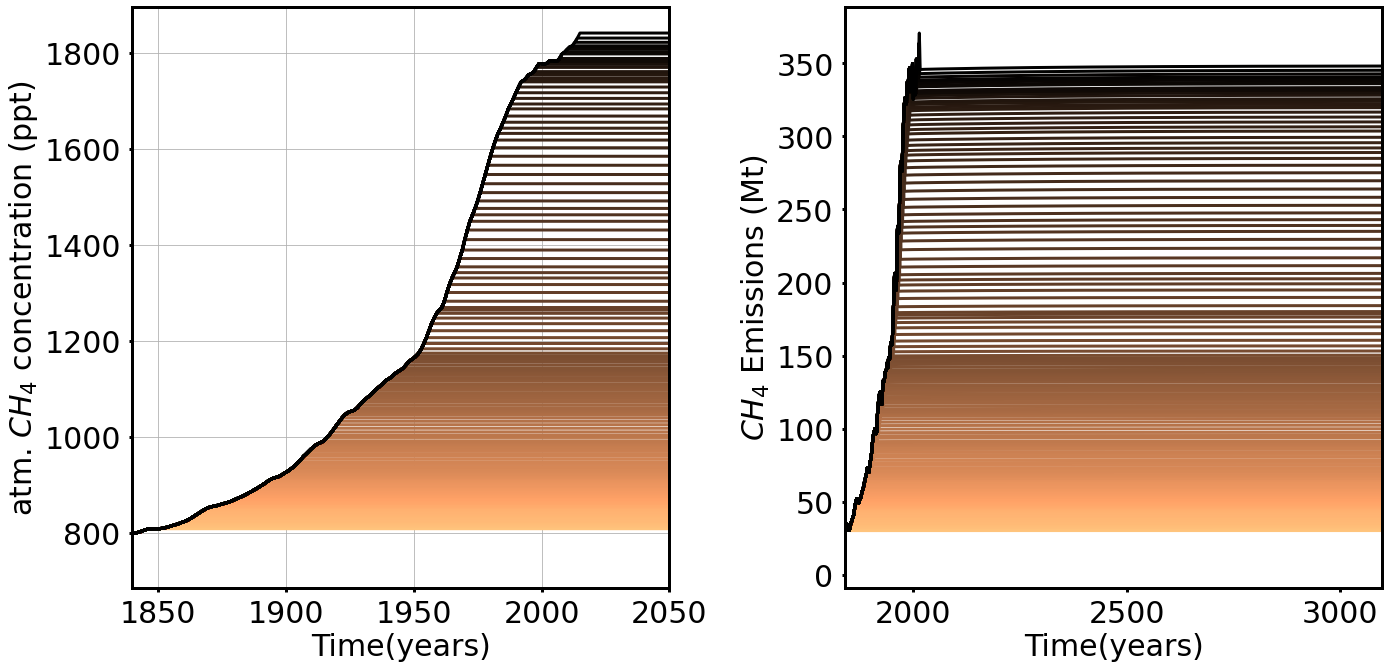

In [4]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
conc_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
conc_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

Convert emission output from the concentration based run to an input DataFrame (delete the Gas cycle row and rename to Gas):

In [5]:
control_in = conc_out['Emissions'].droplevel(1,axis=1)
control_in.columns = control_in.columns.rename("Gas", level=1)

## 2. Control run

In [6]:
control_out = run_FaIR(emissions_in=control_in,forcing_in=return_empty_forcing(control_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1687.39 timestep/s]


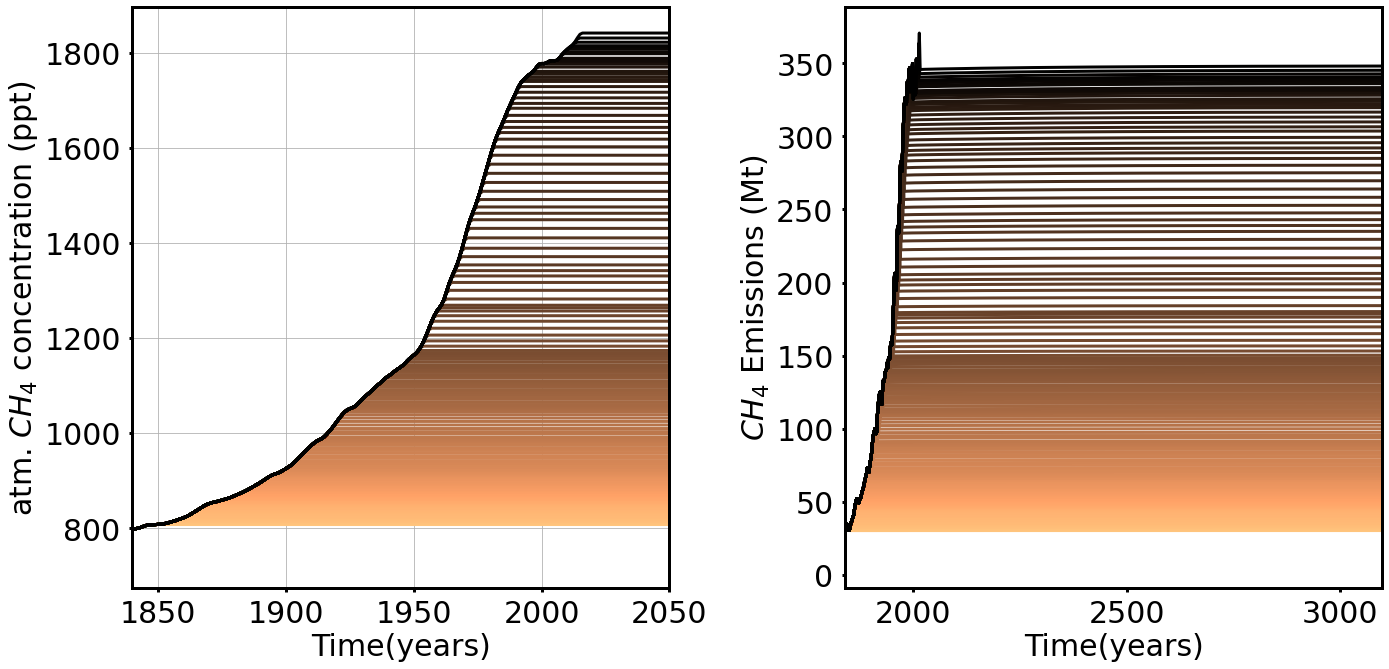

In [7]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
control_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
control_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

## 3. Get Methane data

In [29]:
primap = pd.read_csv('data/Guetschow-et-al-2021-PRIMAP-hist_v2.3.1_20-Sep_2021.csv')

In [41]:
primap.columns

Index(['source', 'scenario (PRIMAP-hist)', 'area (ISO3)', 'entity', 'unit',
       'category (IPCC2006_PRIMAP)', '1750', '1751', '1752', '1753',
       ...
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'],
      dtype='object', length=276)

In [43]:
primap = primap.rename(columns={"category (IPCC2006_PRIMAP)": "category",
                                "area (ISO3)":"ISO3",
                                "scenario (PRIMAP-hist)":"scenario"})

In [58]:
#select the HISTCR scenario (country-reported data is prioritized over third-party data)
primap = primap[primap.scenario=='HISTCR']

# select National Total excluding LULUCF
primap = primap[primap.category=='M.0.EL']

In [109]:
ch4 = primap[primap.entity=='CH4'].set_index('ISO3')
ch4= ch4.loc[:,[str(t) for t in range(1750,2020)]]
ch4.columns = ch4.columns.astype('int')
# convert Gg to Mt
ch4 = ch4/1000

In [110]:
ch4

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
ISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.000014,0.000014,0.000014,0.000014,0.000014,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.001430,0.002040,0.001240,0.001620,0.00151,0.001390,0.001280,0.001170,0.001140,0.001130
AFG,0.085000,0.085400,0.085700,0.086100,0.086400,0.086800,0.087100,0.087500,0.087800,0.088200,...,0.632000,0.652000,0.649000,0.649000,0.66400,0.635000,0.630000,0.625000,0.636000,0.666000
AGO,0.057100,0.057100,0.057100,0.057100,0.057100,0.057200,0.057200,0.057200,0.057200,0.057200,...,2.190000,2.120000,2.130000,2.170000,2.11000,2.220000,2.190000,2.170000,2.110000,2.170000
AIA,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000143,0.000144,0.000146,0.000148,0.00015,0.000151,0.000152,0.000153,0.000154,0.000159
ALB,0.015200,0.015300,0.015300,0.015400,0.015400,0.015500,0.015500,0.015600,0.015600,0.015700,...,0.094300,0.094400,0.096000,0.096800,0.09880,0.101000,0.100000,0.101000,0.101000,0.098000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.000228,0.000230,0.000231,0.000232,0.000233,0.000234,0.000236,0.000237,0.000238,0.000239,...,0.006880,0.007100,0.007150,0.007300,0.00759,0.007960,0.008150,0.007980,0.008160,0.008300
YEM,0.060900,0.061000,0.061100,0.061200,0.061300,0.061400,0.061500,0.061600,0.061700,0.061800,...,0.340000,0.360000,0.374000,0.396000,0.38900,0.334000,0.319000,0.320000,0.311000,0.328000
ZAF,0.009920,0.009950,0.009990,0.010000,0.010100,0.010100,0.010100,0.010100,0.010200,0.010200,...,2.390000,2.470000,2.530000,2.450000,2.48000,2.460000,2.450000,2.420000,2.410000,2.440000


<AxesSubplot:>

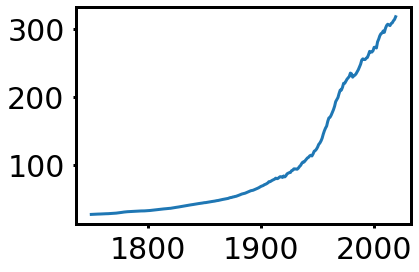

In [125]:
ch4.loc['EARTH'].plot()

In [130]:
import copy
pulse_in = copy.deepcopy(control_in)
for t in range(1850,2016):
    pulse_in.loc[t,'yr_'+str(t)].methane = pulse_in.loc[t,'yr_'+str(t)].methane + ch4.loc['EARTH',t]

In [140]:
pulse_out = run_FaIR(emissions_in=pulse_in,forcing_in=return_empty_forcing(pulse_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 166 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1448.08 timestep/s]


In [141]:
# each century own color, shading for decadals
l = []
for c in [["546A7B",5],["62929E",10],["C6C5B9",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 4 years
l = l[:-4]

co2_cmap=colors.ListedColormap(l)

# each century own color, shading for decadals
l = []
for c in [["9E2A2B",5],["BF6535",10],["E09F3E",2]]:
    l = l+ [(colors.to_rgba('#'+c[0],i)) for i in np.linspace(0.2,1,10)]*c[1]
# remove last 5 years
l = l[:-4]

T_cmap=colors.ListedColormap(l)

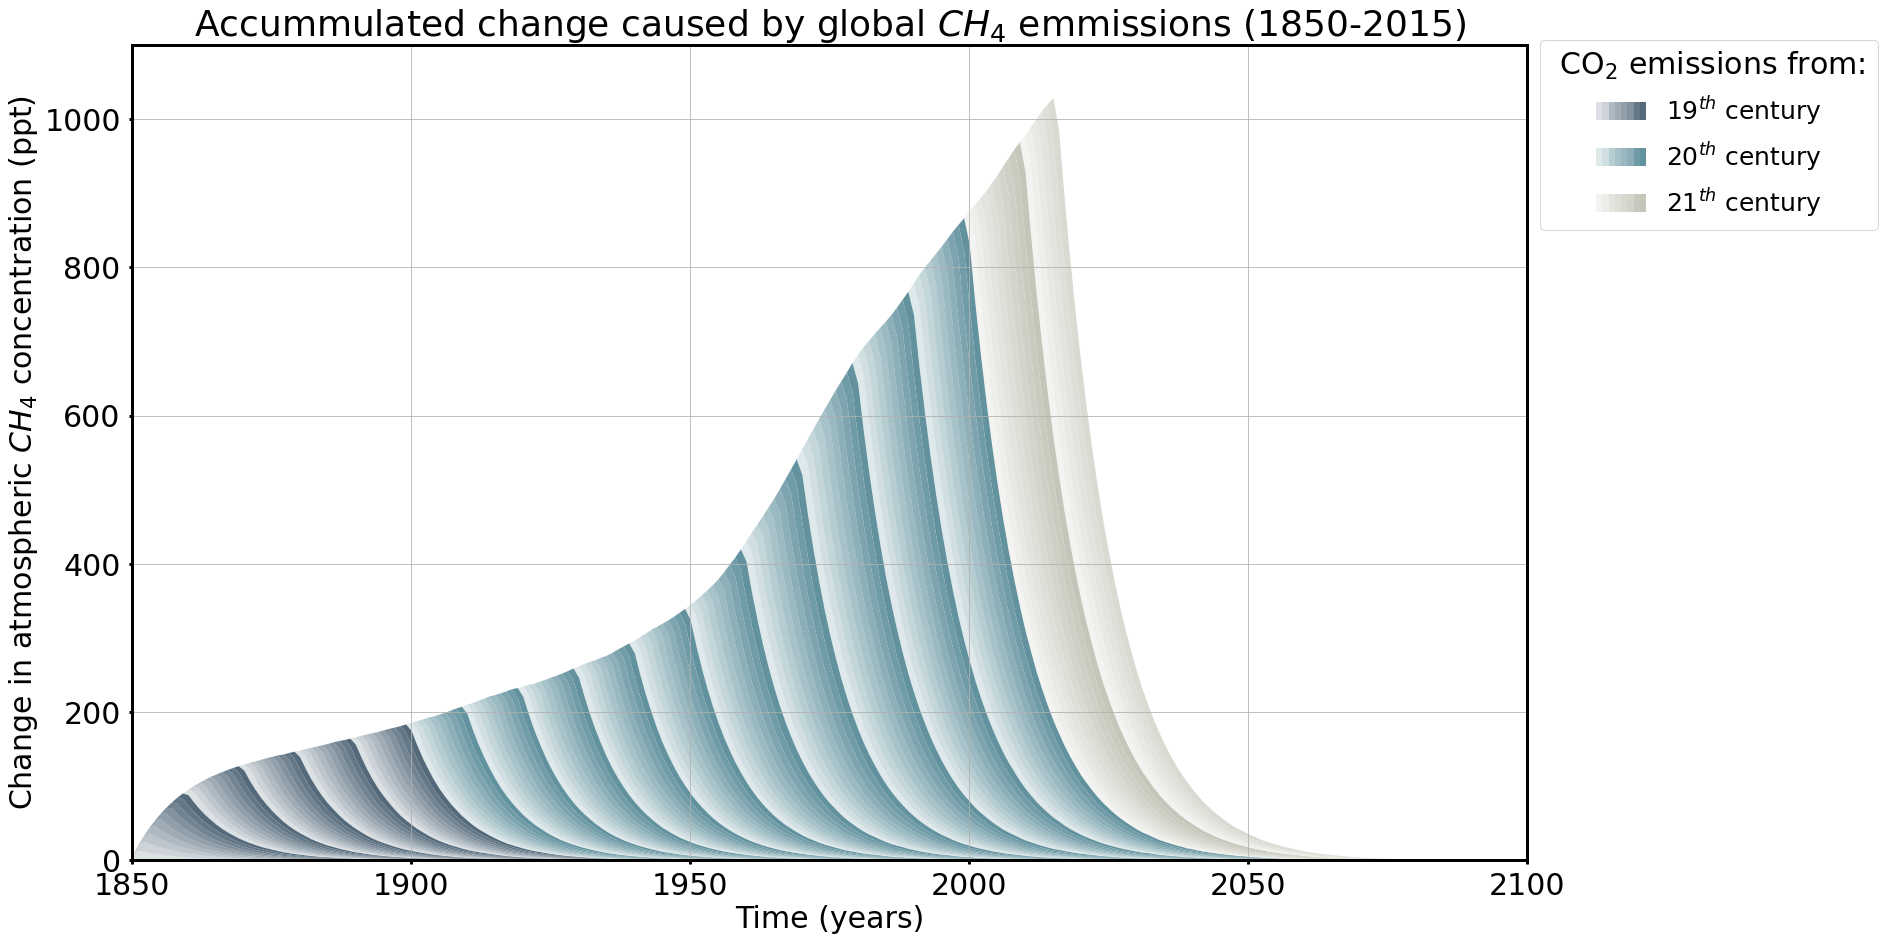

In [203]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0])

ch4_diff = (pulse_out['C']-control_out['C']).droplevel(1,axis=1).round(1)
ch4_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=co2_cmap)

ax1.grid()


ax1.set_xlim(1850,2100)

ax1.set_ylim(0,1100)

ax1.set_xlabel(None)

ax1.set_ylabel(r'Change in atmospheric $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("546A7B"),color_to_cmap("62929E"),color_to_cmap("C6C5B9")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r' CO$_2$ emissions from: ')

In [312]:
T_diff = (pulse_out['T']-control_out['T']).droplevel(1,axis=1)
# cut all values smaller than 5e-4 down to zero (due to effect of error propagation)
T_diff[T_diff.le(5e-4)]=0

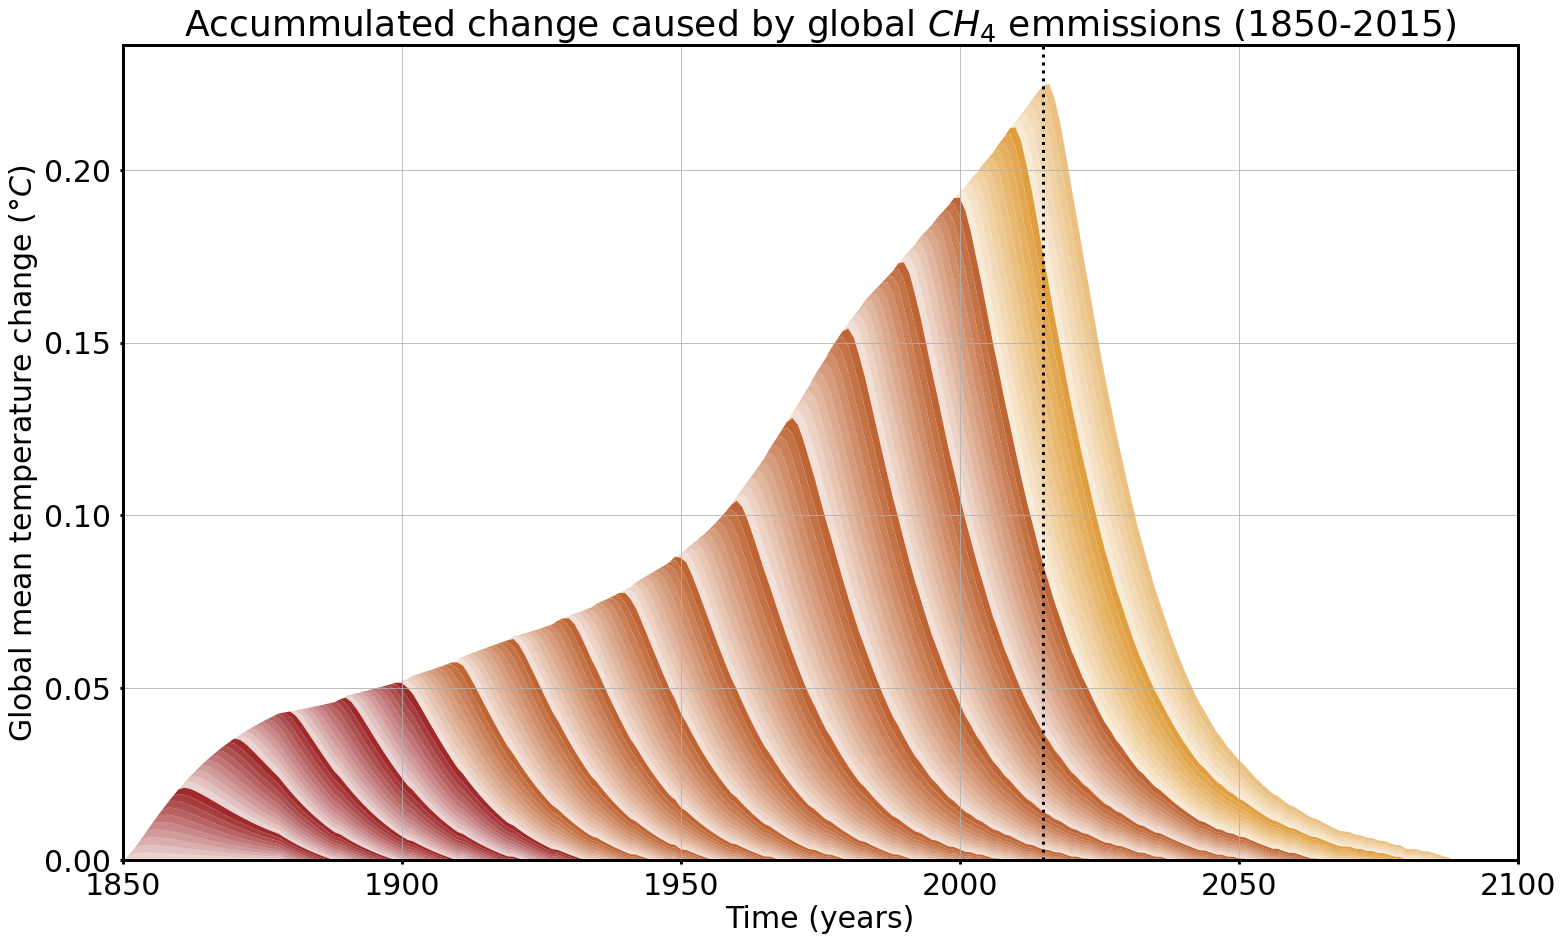

In [315]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0)
ax1 = plt.subplot(grid[0])

T_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)

#ax1.plot(ccr_mean,lw=2,c='r')
#ax1.fill_between(ccr_05p.index,ccr_05p.values,ccr_95p.values,color='r',alpha=0.2)

ax1.grid()


ax1.set_xlim(1850,2100)

ax1.set_xlabel(None)
ax2.set_xlabel(None)

ax1.axvline(2015,linestyle=':',c='k')

ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2015)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("9E2A2B"),color_to_cmap("BF6535"),color_to_cmap("E09F3E")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
legend1 = ax2.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r'CO$_2$ emissions from: ')
p1 = Line2D([0], [0], color='r', lw=2)
p2 = mpatches.Patch(color='r', alpha=0.2, linewidth=0)

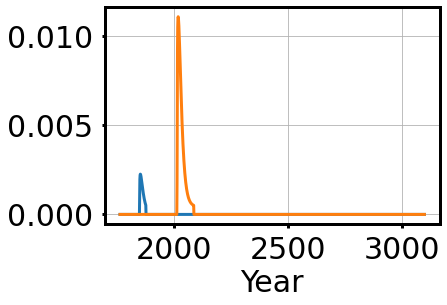

In [314]:
T_diff.loc[:,'yr_1850'].plot()
T_diff.loc[:,'yr_2015'].plot()
plt.grid()

In [302]:
T_diff = (pulse_out['T']-control_out['T']).droplevel(1,axis=1)
T_diff[T_diff.le(5e-4)]=0
T_diff.loc[1850:2050]

Scenario,yr_1850,yr_1851,yr_1852,yr_1853,yr_1854,yr_1855,yr_1856,yr_1857,yr_1858,yr_1859,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
Year,,,,,,,,,,,,,,,,,,,,,
1850,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1851,0.001280,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1852,0.001970,0.001283,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1853,0.002200,0.001975,0.001291,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1854,0.002257,0.002205,0.001987,0.001296,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001505,0.001606,0.001729,0.001829,0.001991,0.002154,0.002314,0.002465,0.002628,0.002839
2047,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001418,0.001512,0.001625,0.001718,0.001869,0.002019,0.002169,0.002309,0.002460,0.002657
2048,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001338,0.001424,0.001530,0.001615,0.001755,0.001895,0.002033,0.002164,0.002304,0.002488


In [306]:
1e-3

0.001

(1840.0, 2536.75)

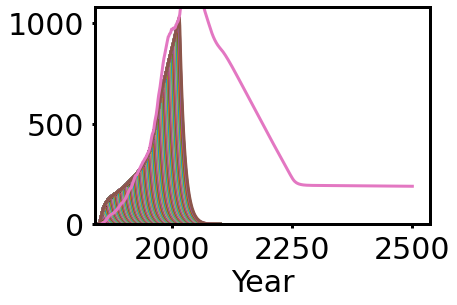

In [197]:
ch4_diff.round(1).loc[:2100].plot.area(legend=False)
plt.plot(ssp245.Concentrations.year,ssp245.Concentrations.ch4-ssp245.Concentrations.ch4[ssp245.Concentrations.year==1850])
plt.xlim(1840,None)

In [194]:
ssp245.Concentrations.ch4[ssp245.Concentrations.year==2020]-ssp245.Concentrations.ch4[ssp245.Concentrations.year==1850]

array([1102.7216035])